## Build and Train a CNN Model for Detecting Pneumonia in X-Rays

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
7953,00002077_002.png,No Finding,2,2077,23,F,PA,2282,2991,0.143,0.143,NaN,/data/images_002/images/00002077_002.png
51603,00013034_001.png,No Finding,1,13034,70,F,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00013034_001.png
6124,00001654_003.png,No Finding,3,1654,50,F,PA,2048,2500,0.168,0.168,NaN,/data/images_002/images/00001654_003.png


## Create One-hot encoding for the Finding Labels

In order for the model to properly train on the different disease labels in Finding Labels, there needs to be a column for each disease with a value of 0 for not present and a value of 1 for disease present.

In [3]:
# split the Finding Labels to separate diseases
split_labels = list()
for i in range(len(all_xray_df)):
    split_labels.append(all_xray_df.loc[i, 'Finding Labels'].split('|'))

all_xray_df['Finding Labels'] = split_labels
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png


In [4]:
# get the unique values for the Finding Labels
# create a set of all unique findings
unique_labels = set([x for label in split_labels for x in label])
print(unique_labels)

{'Hernia', 'Emphysema', 'Fibrosis', 'Mass', 'Pleural_Thickening', 'Nodule', 'Infiltration', 'Pneumonia', 'Effusion', 'No Finding', 'Edema', 'Consolidation', 'Atelectasis', 'Pneumothorax', 'Cardiomegaly'}


In [5]:
# create a copy of the all_xray_df
all_xray_dummies = all_xray_df.copy()

In [6]:
# from the EDA use the most commonly found co-diseases and pneumonia to create dummy variables
common_codisease = ['Pneumonia', 'Consolidation', 'Infiltration', 'Effusion', 'Atelectasis', 'Edema']

# iterate through the list and create a one-hot encoded column
for name in common_codisease:
    # create dummy column with 0s to start
    all_xray_dummies[name] = [0]*len(all_xray_dummies)


In [7]:
all_xray_dummies.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Pneumonia,Consolidation,Infiltration,Effusion,Atelectasis,Edema
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png,0,0,0,0,0,0
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png,0,0,0,0,0,0
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png,0,0,0,0,0,0
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png,0,0,0,0,0,0
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png,0,0,0,0,0,0


In [8]:
# iiterate through the rows and assign a one to the column with the finding
for idx, row in all_xray_dummies.iterrows():
    for x in row['Finding Labels']:
        if x in common_codisease:
            all_xray_dummies.loc[idx,[x]] = 1

In [9]:
# check at the one-hot encoding was done correctly
pd.concat([all_xray_dummies.loc[:15, ['Finding Labels']], all_xray_dummies.iloc[:15, -15:]], axis=1)

,Finding Labels,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Pneumonia,Consolidation,Infiltration,Effusion,Atelectasis,Edema
0,[Cardiomegaly],58.0,M,PA,2682.0,2749.0,0.143,0.143,NaN,/data/images_001/images/00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0
1,"[Cardiomegaly, Emphysema]",58.0,M,PA,2894.0,2729.0,0.143,0.143,NaN,/data/images_001/images/00000001_001.png,0.0,0.0,0.0,0.0,0.0,0.0
2,"[Cardiomegaly, Effusion]",58.0,M,PA,2500.0,2048.0,0.168,0.168,NaN,/data/images_001/images/00000001_002.png,0.0,0.0,0.0,1.0,0.0,0.0
3,[No Finding],81.0,M,PA,2500.0,2048.0,0.171,0.171,NaN,/data/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0
4,[Hernia],81.0,F,PA,2582.0,2991.0,0.143,0.143,NaN,/data/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0
5,[Hernia],74.0,F,PA,2500.0,2048.0,0.168,0.168,NaN,/data/images_001/images/00000003_001.png,0.0,0.0,0.0,0.0,0.0,0.0
6,[Hernia],75.0,F,PA,2048.0,2500.0,0.168,0.168,NaN,/data/images_001/images/00000003_002.png,0.0,0.0,0.0,0.0,0.0,0.0
7,"[Hernia, Infiltration]",76.0,F,PA,2698.0,2991.0,0.143,0.143,NaN,/data/images_001/images/00000003_003.png,0.0,0.0,1.0,0.0,0.0,0.0
8,[Hernia],77.0,F,PA,2500.0,2048.0,0.168,0.168,NaN,/data/images_001/images/00000003_004.png,0.0,0.0,0.0,0.0,0.0,0.0
9,[Hernia],78.0,F,PA,2686.0,2991.0,0.143,0.143,NaN,/data/images_001/images/00000003_005.png,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# check for NaN values
all_xray_dummies.isna().sum()

Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
path                                0
Pneumonia                           0
Consolidation                       0
Infiltration                        0
Effusion                            0
Atelectasis                         0
Edema                               0
dtype: int64

#### Only the Unnamed column has NaN values and it is all NaN values


In [11]:
# drop the Unnamed: 11 column
all_xray_dummies = all_xray_dummies.drop(columns=['Unnamed: 11'])
all_xray_dummies.isna().sum()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
path                           0
Pneumonia                      0
Consolidation                  0
Infiltration                   0
Effusion                       0
Atelectasis                    0
Edema                          0
dtype: int64

In [12]:
# create a target column with pneumonia or no_pneumonia as values
all_xray_dummies['Target'] = all_xray_dummies['Pneumonia'].replace(to_replace=[1, 0], value=['pneumonia', 'no_pneumonia'])
all_xray_dummies['Target'].value_counts()

no_pneumonia    110689
pneumonia         1431
Name: Target, dtype: int64

## Create your training and testing data:

For the first round of training, I will focus on having the training data with an even split of pneumonia and no pneumonia

In [13]:
def create_splits(df):
    ''' 
        The input is a dataframe
        The function will have two outputs a training dataframe and a validation dataframe
        This function will focus on splitting with a balanced set of pneumonia and non-pneumonia for the training set
        Validation dataset will not have any requirements for balanced data
    '''
    
    # create a split of pneumonia and non-pneumonia
    pneum = df[df['Pneumonia'] == 1]
    no_pneum = df[df['Pneumonia'] == 0]
    
    
    # get 80% training set with 50% being pneumonia positive, thus take 80% of the pneumonia positive data

    # shuffle the pneum data for random selection
    shuffled_pneum = pneum.sample(frac=1).reset_index(drop=True)

    # take the top 80% of the shuffled dataframe for training positive results
    index = round(len(shuffled_pneum)*0.8)
    train_pneum = shuffled_pneum[:index]

    # take the rest of the dataframe for the testing data
    val_pneum = shuffled_pneum[index:]

    # shuffle the no_pneum data for random selection
    shuffled_no_pneum = no_pneum.sample(frac=1).reset_index(drop=True)

    # take the top amount equal to the length of the pneum dataframe
    index = len(train_pneum)
    train_no_pneum = shuffled_no_pneum[:index]

    # test that the length of pneumonia and no pneumonia are equal
    assert len(train_pneum) == len(train_no_pneum)

    # concatenate the two dataframes into one training dataframe
    train_df = pd.concat([train_pneum, train_no_pneum], axis=0)

    # shuffle the train_df to get randomness for positive and negative pneumonia
    train_df = train_df.sample(frac=1).reset_index(drop=True)


    # create a testing dataset of no pneum with 3 times as many no pneum
    val_no_pneum = shuffled_no_pneum[-(3*len(val_pneum)):]



    # concatenate the two testing dataframes
    val_df = pd.concat([val_pneum, val_no_pneum])

    
    
    return train_df, val_df

In [14]:
# test the function
train_df, val_df = create_splits(all_xray_dummies)
len(train_df), len(val_df)

(2290, 1144)

In [15]:
# check that the train_df has equal number of pneumonia and no_pneumonia
train_df['Target'].value_counts()

no_pneumonia    1145
pneumonia       1145
Name: Target, dtype: int64

In [16]:
# check validation split of pneumonia
val_df['Target'].value_counts()

no_pneumonia    858
pneumonia       286
Name: Target, dtype: int64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

Augmentation will be started at with **horizontal flip set to True**, **height shift range = 0.10**, **width shift range = 0.10**, **rotation = 10**, **zoom = 0.10**

This some augmentation but not excessive and should mimic real life examples while providing variety for the model to become more robust to variation.

In [17]:
# most common image size
IMAGE_SIZE=(224,224)


def my_image_augmentation(ht_shft = 0.10, wd_shft = 0.10, rotate = 10, zoom = 0.1):
    
    # instantiate a generator object to augment the images for the training data
    train_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = True,
                                       vertical_flip = False,
                                       height_shift_range = ht_shft,
                                       width_shift_range = wd_shft,
                                       rotation_range = rotate,
                                       shear_range = 0.0, zoom_range = zoom)
    
    
    
    return train_datagen


def make_train_gen(df):
    
    train_datagen = my_image_augmentation()
    
    train_generator = train_datagen.flow_from_dataframe(
                                                        dataframe = df, 
                                                        directory = None, 
                                                        x_col = 'path',
                                                        y_col = 'Target',
                                                        class_mode = 'binary',
                                                        target_size = IMAGE_SIZE, 
                                                        batch_size = 32)
    return train_generator


def make_val_gen(val_df):
    
    my_val_idg = my_image_augmentation(ht_shft=0.0, wd_shft=0.0, rotate=0, zoom=0.0)
    
    val_gen = my_val_idg.flow_from_dataframe(
                                            dataframe = val_df, 
                                            directory = None, 
                                            x_col = 'path',
                                            y_col = 'Target',
                                            class_mode = 'binary',
                                            target_size = IMAGE_SIZE, 
                                            batch_size = 1024)
    
    return val_gen

In [18]:
# ## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_df)
valX, valY = val_gen.next()


Found 1144 validated image filenames belonging to 2 classes.


In [19]:
# get the training data
train_gen = make_train_gen(train_df)

Found 2290 validated image filenames belonging to 2 classes.


## View the Augmented Images

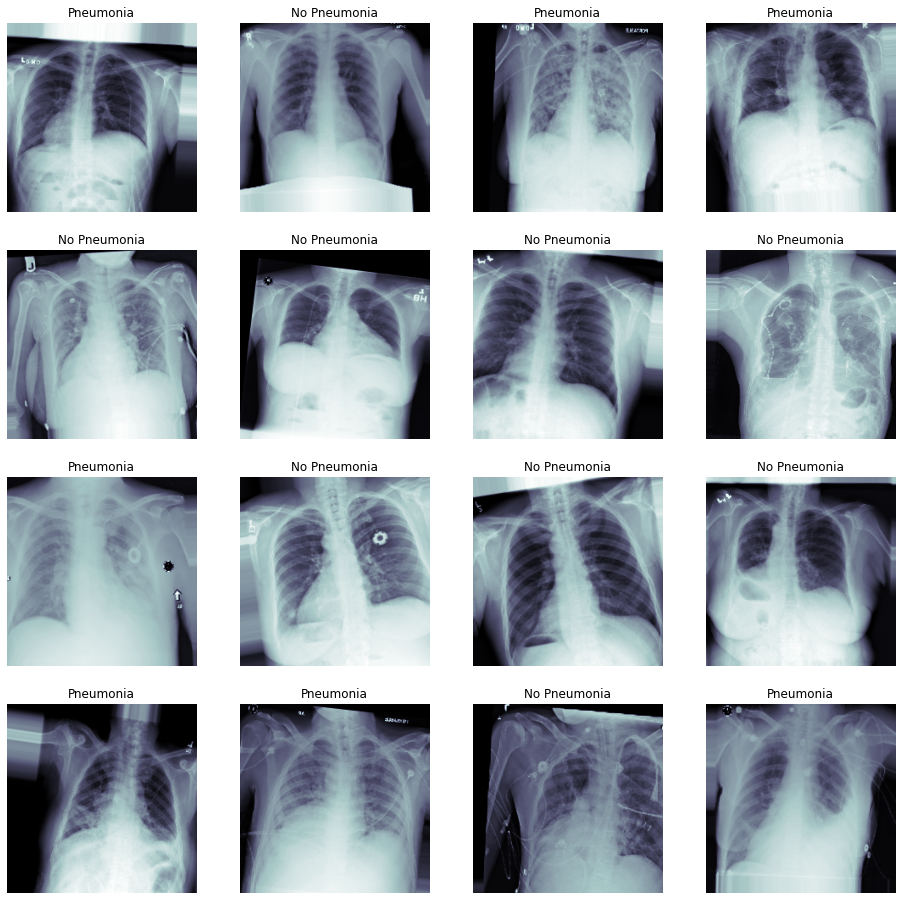

In [20]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [25]:
def load_pretrained_model(transfer_layer='block5_pool'):
    
    # instantiate the model of the VGG16 imagenet model
    model = VGG16(include_top=True, weights='imagenet')
    # use pretrained layers up to and including the transfer layer
    transf_layer = model.get_layer(transfer_layer)
    vgg_model = Model(inputs = model.input, outputs = transf_layer.output)
    
    # freeze pretrained layers
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    # print the layers
    print('VGG Layers:')
    for layer in vgg_model.layers:
        print(layer.name, 'Trainable:', layer.trainable)
    
    return vgg_model

In [26]:
# test that the model can be created from the function
vgg_model = load_pretrained_model()

VGG Layers:
input_3 Trainable: False
block1_conv1 Trainable: False
block1_conv2 Trainable: False
block1_pool Trainable: False
block2_conv1 Trainable: False
block2_conv2 Trainable: False
block2_pool Trainable: False
block3_conv1 Trainable: False
block3_conv2 Trainable: False
block3_conv3 Trainable: False
block3_pool Trainable: False
block4_conv1 Trainable: False
block4_conv2 Trainable: False
block4_conv3 Trainable: False
block4_pool Trainable: False
block5_conv1 Trainable: False
block5_conv2 Trainable: False
block5_conv3 Trainable: True
block5_pool Trainable: True


In [27]:
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Build the Trainable Layers of the Model


In [60]:

def build_my_model():
    
    # load the pretrained model
    vgg_model = load_pretrained_model()
    
    # instantiate the new model
    new_model = Sequential()
    
    # add the vgg layers
    new_model.add(vgg_model)
    new_model.add(Flatten())
    
    # some more hidden layers and dropout layers
    new_model.add(Dropout(0.2))
    new_model.add(Dense(activation = 'relu', units = 1024))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(activation = 'relu', units = 512))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(activation = 'relu', units = 256))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(activation = 'relu', units = 128))
    
        
    # create the output layer with one node and use sigmoid activation
    new_model.add(Dense(activation='sigmoid', units = 1))

    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

In [61]:
# build the model
my_model = build_my_model()

VGG Layers:
input_6 Trainable: False
block1_conv1 Trainable: False
block1_conv2 Trainable: False
block1_pool Trainable: False
block2_conv1 Trainable: False
block2_conv2 Trainable: False
block2_pool Trainable: False
block3_conv1 Trainable: False
block3_conv2 Trainable: False
block3_conv3 Trainable: False
block3_pool Trainable: False
block4_conv1 Trainable: False
block4_conv2 Trainable: False
block4_conv3 Trainable: False
block4_pool Trainable: False
block5_conv1 Trainable: False
block5_conv2 Trainable: False
block5_conv3 Trainable: True
block5_pool Trainable: True


In [62]:
my_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)              

In [63]:
# define the optimizers and loss function
optimizer = Adam(lr = 1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
    
# compile the model
my_model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    

In [64]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

from keras.callbacks import ModelCheckpoint, EarlyStopping

# create path for storing the best model from this first model design
weight_path="{}_my_model_1.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]


### Start training! 

In [65]:
## train your model
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 100, 
                          callbacks = callbacks_list)

Epoch 1/100
72/72 [==============================] - 69s 962ms/step - loss: 0.7130 - binary_accuracy: 0.5245 - val_loss: 0.7191 - val_binary_accuracy: 0.4238

Epoch 00001: val_loss improved from inf to 0.71909, saving model to xray_class_my_model_1.best.hdf5
Epoch 2/100
72/72 [==============================] - 62s 861ms/step - loss: 0.6875 - binary_accuracy: 0.5459 - val_loss: 0.7565 - val_binary_accuracy: 0.3271

Epoch 00002: val_loss did not improve from 0.71909
Epoch 3/100
72/72 [==============================] - 61s 841ms/step - loss: 0.6667 - binary_accuracy: 0.5913 - val_loss: 0.6162 - val_binary_accuracy: 0.6777

Epoch 00003: val_loss improved from 0.71909 to 0.61620, saving model to xray_class_my_model_1.best.hdf5
Epoch 4/100
72/72 [==============================] - 59s 824ms/step - loss: 0.6539 - binary_accuracy: 0.6127 - val_loss: 0.6877 - val_binary_accuracy: 0.5840

Epoch 00004: val_loss did not improve from 0.61620
Epoch 5/100
72/72 [==============================] - 67s 9

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [66]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

1024/1024 [==============================] - 12s 11ms/step


In [67]:
pred_Y

array([[0.3406927 ],
       [0.43260992],
       [0.59296054],
       ...,
       [0.5126121 ],
       [0.08523941],
       [0.21471184]], dtype=float32)

In [69]:
from sklearn.metrics import roc_curve, precision_recall_curve

# build a function for AUC 
def plot_auc(t_y, p_y):
    
    fpr, tpr, threshold = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    
    return plt.show()


# create a function for accuracy
def accuracy(t_y, p_y):
    '''
        (True Negatives + True Positives) / All Values
    '''
    
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for i in range(len(t_y)):
        # find the true positives
        if t_y[i]==1.0 and p_y[i] == 1.0:
            tp += 1
        # find the false positives
        elif t_y[i]==0.0 and p_y[i] == 0.0:
            tn += 1
    
        numerator = tn + tp
        denominator = len(t_y)
    
    return numerator/denominator
    


# build a function for precision
def precision(t_y, p_y):
    '''
       True Positives / (True Positives + False Positives)
    '''
    
    # true positives
    tp = 0
    # false positives
    fp = 0
    
    for i in range(len(t_y)):
        # find the true positives
        if t_y[i]==1.0 and p_y[i] > 0.50:
            tp += 1
        # find the false positives
        elif t_y[i]==0.0 and p_y[i] < 0.50:
            fp += 1
    
    return tp / (tp+fp)



# build a function for sensitivity
def sensitivity(t_y, p_y):
    '''
        True Positives / (True Positives + False Negatives)
    '''
    # true positives
    tp = 0
    # false negatives
    fn = 0
    
    for i in range(len(t_y)):
        # find the true positives
        if t_y[i]==1.0 and p_y[i] > 0.50:
            tp += 1
        # find the false negatives
        elif t_y[i]==1.0 and p_y[i] < 0.50:
            fn += 1
    
    return tp / (tp+fn)



# build a function for F1 score
def f1_score(sens, prec):
    '''
       F1 score is  2 * (Sensitivity * Precision) / (Sensitivity + Precision)
    '''
    
    return 2 * ((sens*prec) / (sens+prec))
    
    
    
# get the metrics for all scores:
def summary_metrics(t_y, p_y):
    acc = accuracy(t_y, p_y)
    print('Accuracy:', acc)    
    prec = precision(t_y, p_y)
    print('Precision:', prec)
    sens = sensitivity(t_y, p_y)
    print('Sensitivity:', sens)
    f1 = f1_score(t_y, p_y)
    print('F1 Score:', f1)
    
    
    
    
# plot the history of the loss function
def plot_loss_history(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    return plt.show()


# plot the history of the accuracy
def plot_accuracy_history(history):
    
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    return plt.show()


def plot_prec_recall(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title('Precision Recall Curve')
    
    return plt.show()

def plot_metrics(t_y, p_y):
    '''
        Create a plot of Accuracy, Precision, Sensitivity, and F1
        vs the threshold on a range of 0.4 to 0.6
    '''
    
    
    # create the threshold range
    thresh_list = list(range(40, 62, 2))
    thresholds = [(x/100) for x in thresh_list]
    
    # create a list for each metric
    acc_list, sens_list, prec_list, f1_list = [], [], [], []
    
    for num in thresholds:
        preds = pred_class(p_y, threshold=num)
        # calculate the metrics and append to list
        acc_list.append(accuracy(t_y, preds))
        prec_list.append(precision(t_y, preds))
        sens_list.append(sensitivity(t_y, preds))
        f1_list.append(f1_score(t_y, preds))
        
    plt.plot(thresholds, acc_list, color='red', label='Accuracy')
    plt.plot(thresholds, prec_list, color='blue', label='Precision')
    plt.plot(thresholds, sens_list, color='black', label='Sensitivity')
    plt.plot(thresholds, f1_list, color='green', label='F1')
    plt.xlabel("Threshold")
    plt.ylabel("Performance Metric")
    plt.legend()
    plt.title('Summary of Threshold and Statistic Metrics')
    
    return plt.show()

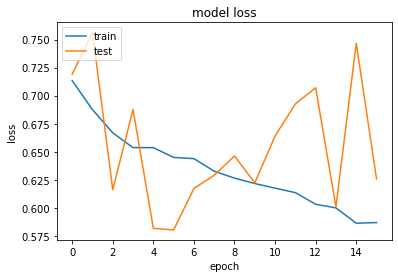

In [70]:
## plot loss history
plot_loss_history(history)

## Model Loss Analysis
The testing loss decreases to a minimum at 4 epochs and then begins to rise while the training loss continues to fall. This means 4 epochs would be a good stopping point for the training and should be where the model saved based on the best performance model.

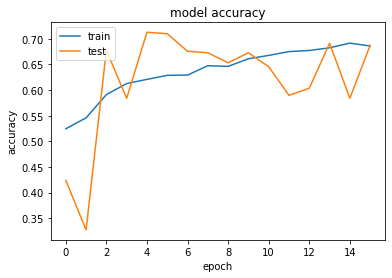

In [71]:
# plot accuracy history
plot_accuracy_history(history)

## Model Accuracy Analysis:
The training accuracy seems to improve with each epoch and the testing accuracy improves quickly then plateaus.

## ROC Curve - Area Under the Curve

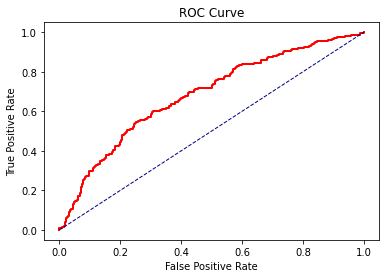

In [72]:
# plot the roc curve
plot_auc(valY, pred_Y)

## ROC Analysis:
The ROC curve is better than a random guessing model indicated by the blue line.

## Precision Vs Recall Curve

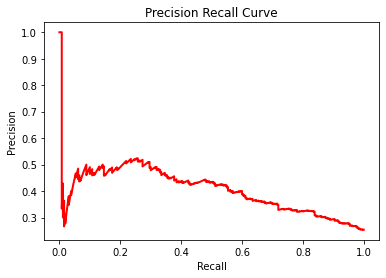

In [73]:
# plot precision recall
plot_prec_recall(valY, pred_Y)

## Precision vs Recall Analysis:

The curve shows that recall improves steadily without affecting Precision up until around 0.27 then it starts to affect Recall.

Text(0.5, 1.0, 'Precision/Recall by threshold')

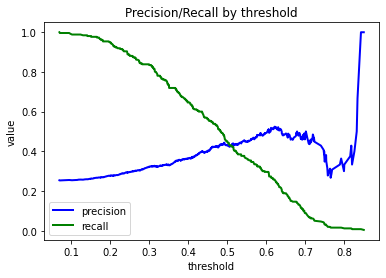

In [74]:
# plot the threshold vs the F1, Precision, Recall, and Accuracy to get a sense of what threshold to use
precisions, recalls, thresholds = precision_recall_curve(valY, pred_Y, pos_label=1)
plt.plot(thresholds, precisions[:-1], color='blue', lw=2, label='precision')
plt.plot(thresholds, recalls[:-1], color='green', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('Precision/Recall by threshold')

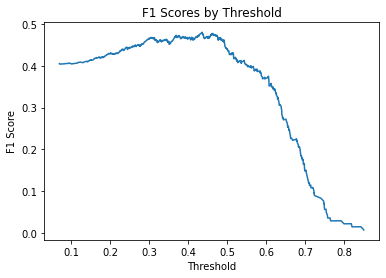

In [78]:
#precisions, recalls, thresholds = precision_recall_curve(valY, pred_Y, pos_label=1)

# list of f1 scores for thresholds
f1_list = []
for i in range(len(thresholds)):
    f1_list.append(f1_score(recalls[i], precisions[i]))
    
plt.plot(thresholds, f1_list)
plt.title('F1 Scores by Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

## Summary of Threshold Analysis
The threshold has the best performance for F1 score around 0.47

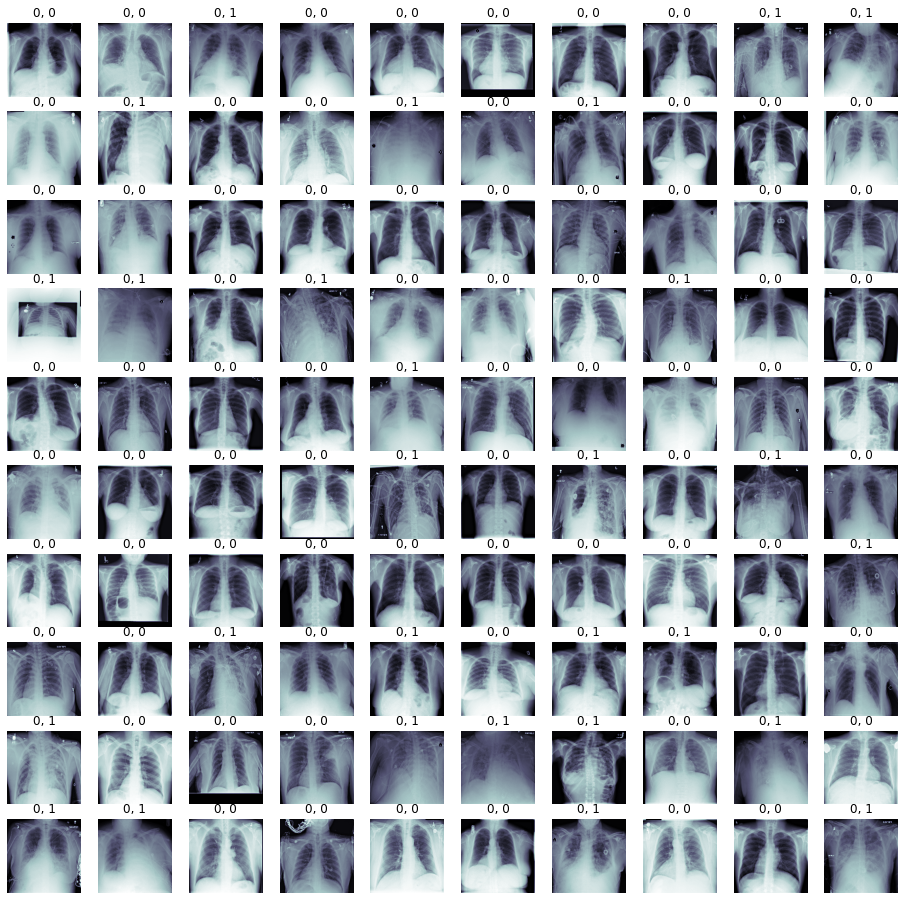

In [81]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], pred_Y[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.47:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.47: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [80]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)